# Forecasting using Traditional Models

In this section, we shall discuss the types of traditional forecasting models and their implementations in the cleaned data we get from chapter 2. We will be forecast

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
from prophet import Prophet

train_url = "https://drive.google.com/uc?id=1XHb5EDd58vx8dsxEtwH5GcMueymDn1g8"
test_url = "https://drive.google.com/uc?id=1X-DyAegNmH1Un_kB-twmVslFy4zMYGrE"
train = pd.read_csv(train_url)
train['invoice_date'] = pd.to_datetime(train['invoice_date'])
train.set_index('invoice_date', inplace=True)
test = pd.read_csv(test_url)
test['invoice_date'] = pd.to_datetime(test['invoice_date'])
test.set_index('invoice_date', inplace=True)
train.head()

,total_quantity
invoice_date,
2009-12-01,20736
2009-12-02,25657
2009-12-03,44557
2009-12-04,19550
2009-12-05,4636


## Classical Models
Classical models are traditional statistical techniques used to forecast time series data **based on patterns like trend, seasonality, and noise**. They do not require training in the way machine learning models do and are **useful when the time series is stable and follows identifiable patterns**.
### 1. Naive and Seasonal Naive
A simple forecasting method where the forecast for the next period is the **last observed value**. It assumes **no trend or seasonality** and is often used as a baseline. Useful for benchmarking other models. It’s computationally inexpensive but ignores patterns, making it less effective for complex data. $$F_{t+1} = Y_t$$
Where $ F_{t+1} $ is the forecast for the next period, and $ Y_t $ is the actual value at time $ t $.
***
**Seasonal Naive Forecasting**

An extension of the naive method that uses the **value from the same season** (e.g., the same day of the week or month) **in the previous cycle** as the forecast. It accounts for **seasonality but not trends**. It is better for data with strong seasonal patterns (e.g., weekly sales cycles).

In our UK sales dataset, a 7-day seasonal period might capture weekly shopping trends. $$F_{t+1} = Y_{t-s}$$
Where $ s $ is the length of the season (e.g., 7 for weekly data), and $ Y_{t-s} $ is the value from the previous season.

***
**Limitations:**

- Both assume constant mean and don’t handle trends or seasonality well unless the window is carefully chosen.

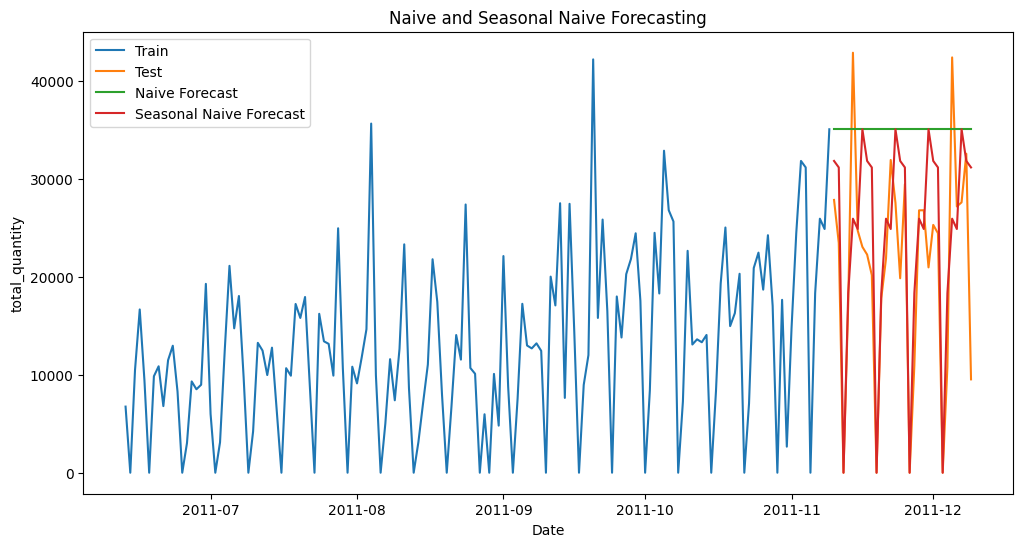

In [ ]:
naive_forecast = np.array([train['total_quantity'].iloc[-1]] * len(test)) # Naive Forecast

seasonal_naive_forecast = train['total_quantity'].iloc[-7:].values # Seasonal Naive Forecast (7-day seasonality)
seasonal_naive_forecast = np.tile(seasonal_naive_forecast, int(np.ceil(len(test) / 7)))[:len(test)]

plt.figure(figsize=(12, 6))
plt.plot(train.index[-150:], train['total_quantity'].iloc[-150:], label='Train')
plt.plot(test.index, test['total_quantity'], label='Test')
plt.plot(test.index, naive_forecast, label='Naive Forecast')
plt.plot(test.index, seasonal_naive_forecast, label='Seasonal Naive Forecast')
plt.title('Naive and Seasonal Naive Forecasting')
plt.xlabel('Date')
plt.ylabel('total_quantity')
plt.legend()
plt.show()

### 2. Moving Average (Simple, Weighted)
**Simple Moving Average (SMA):**

A method that calculates the average of a fixed number of past observations (window) to forecast the next value. It smooths out short-term fluctuations. It is effective for smoothing data with no strong trend or seasonality. In your dataset, a 7-day window might smooth daily sales fluctuations.

 $$F_{t+1} = \frac{1}{n} \sum_{i=t-n+1}^{t} Y_i$$
Where $ n $ is the window size (e.g., 7), and $ Y_i $ are the past $ n $ observations.
***

**Weighted Moving Average (WMA):**

 An extension of SMA where recent observations are given higher weights, allowing more influence on the forecast. It is more responsive to recent changes, making it suitable if sales trends are shifting. Weights decrease for older data, enhancing adaptability.

 $$F_{t+1} = \frac{\sum_{i=t-n+1}^{t} w_i Y_i}{\sum_{i=t-n+1}^{t} w_i}$$
Where $ w_i $ are weights (e.g., linearly decreasing: $ w_i = n-i+1 $), and $ \sum w_i $ is the sum of weights.

***
**Limitations:**

- Limitations: Both assume constant mean and don’t handle trends or seasonality well unless the window is carefully chosen.

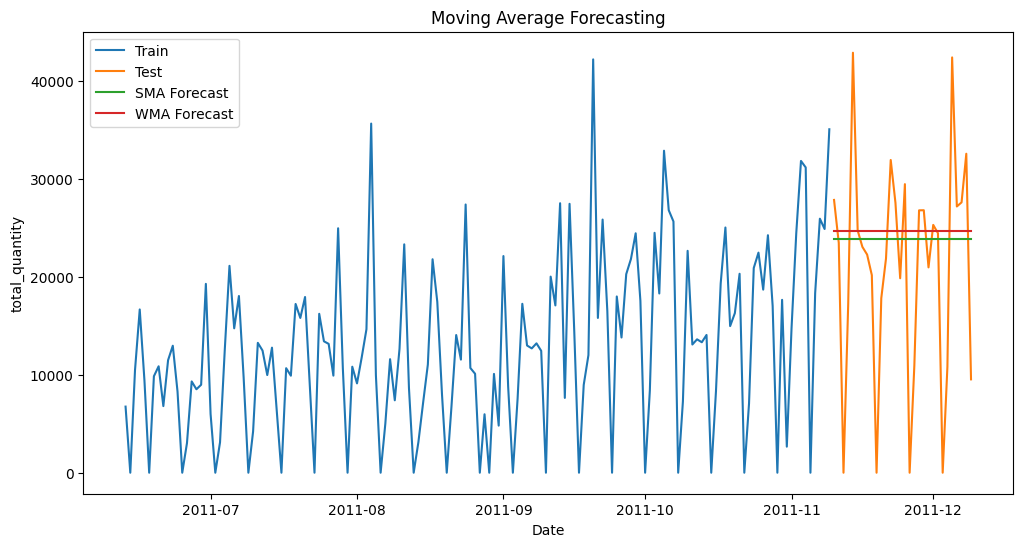

In [ ]:
sma_forecast = train['total_quantity'].rolling(window=7).mean().iloc[-1]
sma_forecast = np.array([sma_forecast] * len(test)) # Simple Moving Average (7-day window)

weights = np.array([1, 2, 3, 4, 5, 6, 7])
weights = weights / weights.sum()
wma_forecast = np.average(train['total_quantity'].iloc[-7:], weights=weights)
wma_forecast = np.array([wma_forecast] * len(test)) # Weighted Moving Average

weights = np.array([1, 2, 3, 4, 5, 6, 7])
weights = weights / weights.sum()
wma_forecast = np.average(train['total_quantity'].iloc[-7:], weights=weights)
wma_forecast = np.array([wma_forecast] * len(test))

plt.figure(figsize=(12, 6))
plt.plot(train.index[-150:], train['total_quantity'].iloc[-150:], label='Train')
plt.plot(test.index, test['total_quantity'], label='Test')
plt.plot(test.index, sma_forecast, label='SMA Forecast')
plt.plot(test.index, wma_forecast, label='WMA Forecast')
plt.title('Moving Average Forecasting')
plt.xlabel('Date')
plt.ylabel('total_quantity')
plt.legend()
plt.show()

### 3. Exponential Smoothing (Simple ES, Holt, Holt-Winters)
Exponential smoothing methods use weighted averages of past observations, with weights decreasing exponentially for older data. They are more adaptive than moving averages and can handle trends and seasonality.

#### 3.1 Simple Exponential Smoothing (SES)
It is a method that applies a smoothing factor to all past data, giving more weight to recent observations. It is suitable for stable sales data without trends or seasonal patterns.
This model is controlled by the **smoothing parameter $ \alpha $ (0 to 1)**, where higher $ \alpha $ gives more weight to recent data.

**Limitations:**
- Fails with trends or seasonality unless extended (e.g., Holt’s or Holt-Winters).

**Forecast Equation:**
$$F_{t+1} = \alpha Y_t + (1 - \alpha) F_t$$
Where $ F_t $ is the forecast for time $ t $, $ Y_t $ is the actual value, and $ \alpha $ is the smoothing parameter.
Initial Forecast: Often set as $ F_1 = Y_1 $

***
#### 3.2 Holt’s Linear Trend
It is an extension of SES that includes a trend component to model data with a linear trend over time. In our case, it is suitable if UK sales show a consistent upward or downward trend (e.g., holiday season increases).

Holt’s Linear Trend uses two smoothing factors—$ \alpha $ for the level and $ \beta $ for the trend.

**Limitations**
- Doesn’t account for seasonality.

**Level Equation**:
$$L_t = \alpha Y_t + (1 - \alpha) (L_{t-1} + T_{t-1})$$

**Trend Equation**:
$$T_t = \beta (L_t - L_{t-1}) + (1 - \beta) T_{t-1}$$

**Forecast Equation**:
$$F_{t+m} = L_t + m T_t$$
Where $ L_t $ is the level, $ T_t $ is the trend, and $ m $ is the forecast horizon.

***

#### 3.3 Holt-Winters
It is an extension of Holt’s method that includes a seasonal component, making it suitable for data with both trend and seasonality. The Holt-Winters method uses three smoothing factors—$ \alpha $ for level, $ \beta $ for trend, and $ \gamma $ for seasonality.

It can use **additive (for linear seasonality)** or **multiplicative (for proportional seasonality)** models.

**Limitations**:
- Requires careful tuning of parameters and a known seasonal period (e.g., 7 days).

**3.3.1 Additive Holt-Winters:**

Level:
$$L_t = \alpha (Y_t - S_{t-s}) + (1 - \alpha) (L_{t-1} + T_{t-1})$$

Trend:
$$T_t = \beta (L_t - L_{t-1}) + (1 - \beta) T_{t-1}$$

Seasonal:
$$S_t = \gamma (Y_t - L_t) + (1 - \gamma) S_{t-s}$$

Forecast:
$$F_{t+m} = L_t + m T_t + S_{t-s+m}$$


Where $ s $ is the seasonal period (e.g., 7), and $ S_t $ is the seasonal component.

**3.3.2 Multiplicative Holt-Winters (if seasonality is proportional)**:

Forecast:
$$F_{t+m} = (L_t + m T_t) \cdot S_{t-s+m}$$


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/

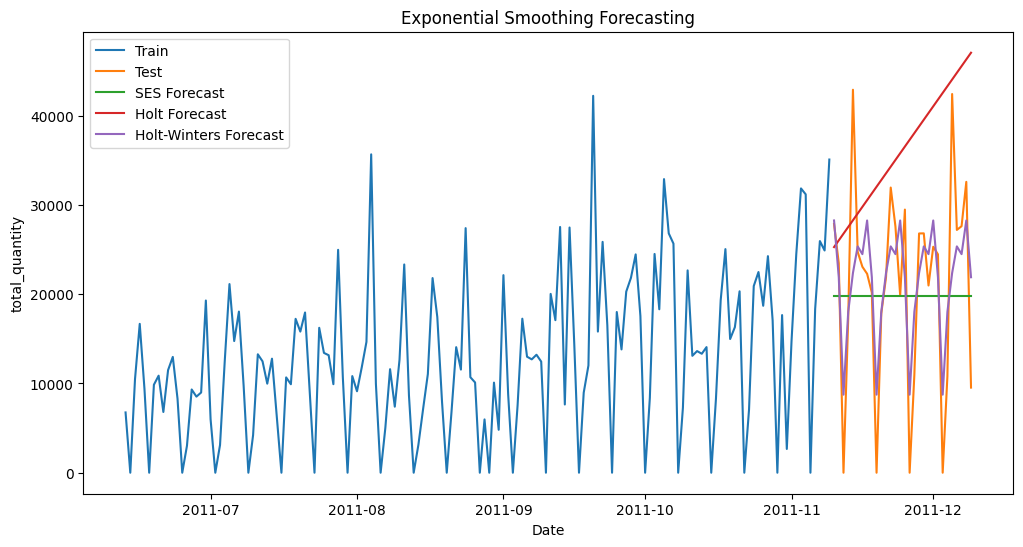

In [ ]:
# Simple Exponential Smoothing
ses_model = SimpleExpSmoothing(train['total_quantity']).fit()
ses_forecast = ses_model.forecast(len(test))

# Holt's Linear Trend
holt_model = Holt(train['total_quantity']).fit()
holt_forecast = holt_model.forecast(len(test))

# Holt-Winters
hw_model = ExponentialSmoothing(train['total_quantity'], seasonal='add', seasonal_periods=7).fit()
hw_forecast = hw_model.forecast(len(test))

plt.figure(figsize=(12, 6))
plt.plot(train.index[-150:], train['total_quantity'].iloc[-150:], label='Train')
plt.plot(test.index, test['total_quantity'], label='Test')
plt.plot(test.index, ses_forecast, label='SES Forecast')
plt.plot(test.index, holt_forecast, label='Holt Forecast')
plt.plot(test.index, hw_forecast, label='Holt-Winters Forecast')
plt.title('Exponential Smoothing Forecasting')
plt.xlabel('Date')
plt.ylabel('total_quantity')
plt.legend()
plt.show()

## Statistical Models
A statistical model is a mathematical representation that uses statistical assumptions and methods to describe and predict the behavior of a dataset, such as time series data. It relies on probabilistic relationships between variables (e.g., past sales influencing future sales) and is typically parameterized to fit observed data, enabling forecasts and inference.

#### **ARIMA from StatsModel**
The ARIMA class in statsmodels is a versatile implementation that can handle various time series models by adjusting the order parameters (p, d, q). In this section we will be implementing the statistical models AR, MA, ARMA and ARIMA using the ARIMA class with the respective values of p, q and r:

> **p**: The number of lag observations (autoregressive terms) included in the model. This corresponds to the AR (AutoRegressive) part.

> **d**: The number of times the data is differenced to make it stationary. This is the I (Integrated) part, which handles trends.

> **q**: The number of lagged forecast errors (moving average terms) included in the model. This corresponds to the MA (Moving Average) part.

The ARIMA class in statsmodels is designed to unify AR, MA, ARMA, and ARIMA models by varying the (p, d, q) parameters:

* **AR**: Set d = 0, q = 0, and choose p > 0 (e.g., (1, 0, 0) for AR(1)).

* **MA**: Set d = 0, p = 0, and choose q > 0 (e.g., (0, 0, 1) for MA(1)).

* **ARMA**: Set d = 0, and choose both p > 0 and q > 0 (e.g., (1, 0, 1)).

* **ARIMA**: Set d > 0 to include differencing, with p and q as needed (e.g., (1, 1, 1)).





### 1. AR Model
The **AutoRegressive (AR) model** predicts future values based on a linear combination of past values (lagged observations) of the same time series. It assumes the series is **stationary**.

**Order** of the model determines the number of lagged terms (e.g., AR(1) uses one lag). It is determined using methods like the **Partial Autocorrelation Function (PACF).**

**Use Case**:

Suitable for sales data with **no clear trend or seasonality but with autocorrelation** (e.g., sales influenced by previous days).

**Limitations:**
- Doesn’t account for moving average effects or seasonality.

**AR(p) Model:**
$$Y_t = c + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \dots + \phi_p Y_{t-p} + \epsilon_t$$
Where:

$ Y_t $ is the value at time $ t $,
$ c $ is a constant,
$ \phi_1, \phi_2, \dots, \phi_p $ are the parameters of the model,
$ \epsilon_t $ is white noise (random error with mean 0 and variance $ \sigma^2 $),
$ p $ is the order of the AR model.


**Forecast:**
$$F_{t+1} = c + \phi_1 Y_t + \phi_2 Y_{t-1} + \dots + \phi_p Y_{t-p+1}$$

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


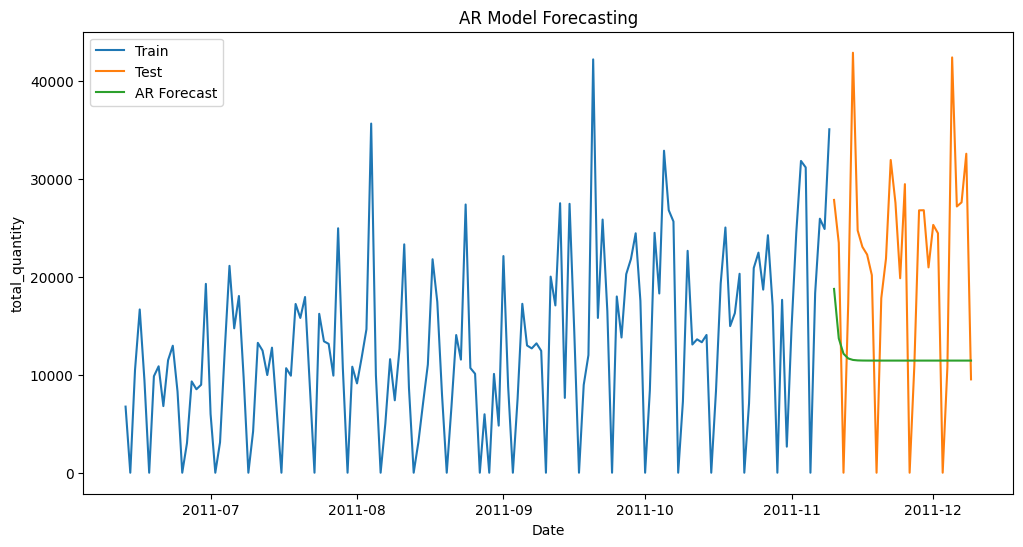

In [ ]:
# AR Model
ar_model = ARIMA(train['total_quantity'], order=(1, 0, 0)).fit()
ar_forecast = ar_model.forecast(steps=len(test))

plt.figure(figsize=(12, 6))
plt.plot(train.index[-150:], train['total_quantity'].iloc[-150:], label='Train')
plt.plot(test.index, test['total_quantity'], label='Test')
plt.plot(test.index, ar_forecast, label='AR Forecast')
plt.title('AR Model Forecasting')
plt.xlabel('Date')
plt.ylabel('total_quantity')
plt.legend()
plt.show()

### 2. MA Model (Moving Average)
The Moving Average (MA) model predicts future values based on a linear combination of past error terms (residuals) rather than past values. It also assumes stationarity. The MA Model is useful when the data shows **short-term shocks** or random fluctuations that affect future values.

The number of lagged error terms (order, q) is determined using the **Autocorrelation Function (ACF)**.

**Limitations**:
- Doesn’t capture long-term dependencies or seasonality.

**MA(q) Model:**
$$Y_t = c + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \dots + \theta_q \epsilon_{t-q}$$
Where:

$ \theta_1, \theta_2, \dots, \theta_q $ are the parameters,
$ \epsilon_t $ is white noise,
$ q $ is the order of the MA model.

**Forecast:**

The forecast depends on past errors, which are estimated from the model fit:
$$F_{t+1} = c + \theta_1 \epsilon_t + \theta_2 \epsilon_{t-1} + \dots + \theta_q \epsilon_{t-q+1}$$
(Errors are typically derived from the residuals of the fitted model.)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


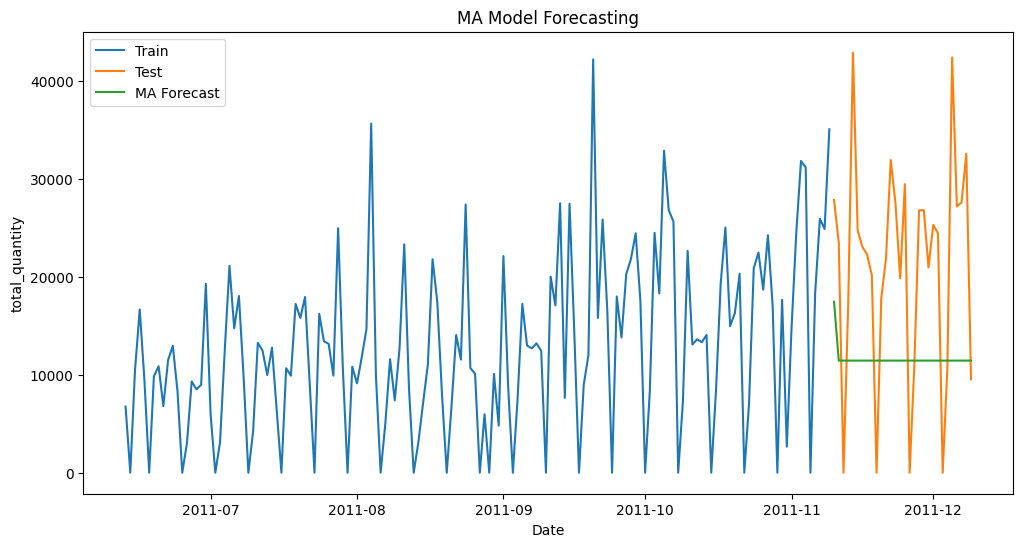

In [ ]:
# MA Model
ma_model = ARIMA(train['total_quantity'], order=(0, 0, 1)).fit()
ma_forecast = ma_model.forecast(steps=len(test))

plt.figure(figsize=(12, 6))
plt.plot(train.index[-150:], train['total_quantity'].iloc[-150:], label='Train')
plt.plot(test.index, test['total_quantity'], label='Test')
plt.plot(test.index, ma_forecast, label='MA Forecast')
plt.title('MA Model Forecasting')
plt.xlabel('Date')
plt.ylabel('total_quantity')
plt.legend()
plt.show()

### 3. ARMA and ARIMA Model

#### 3.1 ARMA Model
**ARMA (AutoRegressive Moving Average)** combines AR and MA models to capture both autoregressive and moving average components. It’s suitable for stationary data. It is effective for **data with autocorrelation and short-term shocks but no trend or seasonality**.

ARMA(p, q) Model:
$$Y_t = c + \phi_1 Y_{t-1} + \dots + \phi_p Y_{t-p} + \epsilon_t + \theta_1 \epsilon_{t-1} + \dots + \theta_q \epsilon_{t-q}$$

where, $ p $ is the AR order

$ q $ is the MA order

**Limitations:**
- ARMA doesn’t handle seasonality

***
#### 3.2 ARIMA Model
**ARIMA (AutoRegressive Integrated Moving Average)** is an extension of ARMA that **includes differencing (integration)** to make a non-stationary series stationary before applying ARMA. It is ideal when the data has a trend (e.g., gradual sales growth) that can be removed via differencing.

ARIMA is denoted as ARIMA(p, d, q), where:

$ p $ is the AR order,

$ d $ is the number of differences (to achieve stationarity),

$ q $ is the MA order.

**ARIMA(p, d, q) Model:**

First, difference the series $ d $ times:
$$\nabla^d Y_t = Y_t - Y_{t-1} \quad \text{(for } d=1\text{)}$$

Then apply ARMA to the differenced series:
$$\nabla^d Y_t = c + \phi_1 \nabla^d Y_{t-1} + \dots + \phi_p \nabla^d Y_{t-p} + \epsilon_t + \theta_1 \epsilon_{t-1} + \dots + \theta_q \epsilon_{t-q}$$

**Limitations:**
- ARIMA addresses trends but not seasonal patterns.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

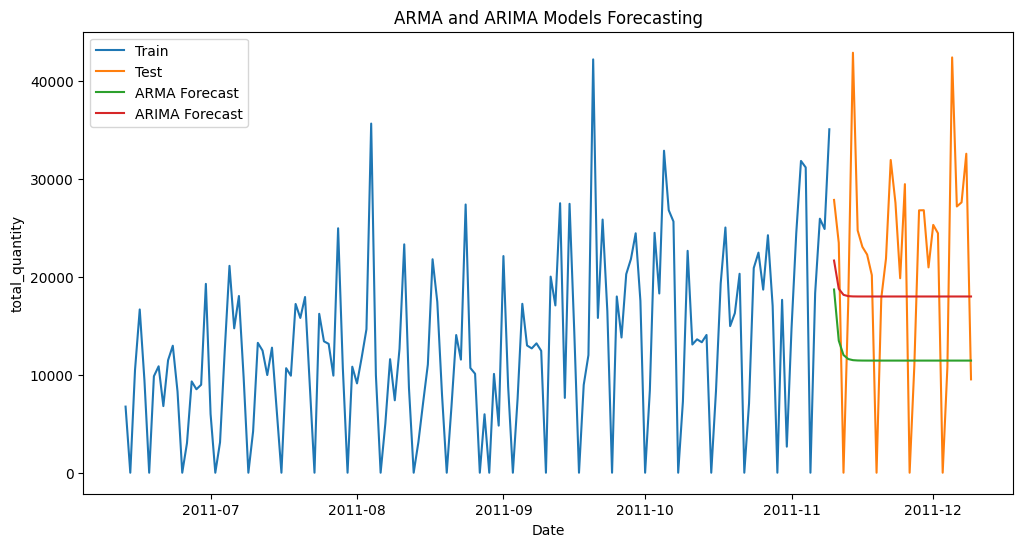

In [ ]:
# ARMA Model
arma_model = ARIMA(train['total_quantity'], order=(1, 0, 1)).fit()
arma_forecast = arma_model.forecast(steps=len(test))

# ARIMA Model
arima_model = ARIMA(train['total_quantity'], order=(1, 1, 1)).fit()
arima_forecast = arima_model.forecast(steps=len(test))

plt.figure(figsize=(12, 6))
plt.plot(train.index[-150:], train['total_quantity'].iloc[-150:], label='Train')
plt.plot(test.index, test['total_quantity'], label='Test')
plt.plot(test.index, arma_forecast, label='ARMA Forecast')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.title('ARMA and ARIMA Models Forecasting')
plt.xlabel('Date')
plt.ylabel('total_quantity')
plt.legend()
plt.show()

### 4. SARIMA model
**Seasonal ARIMA (SARIMA)** extends ARIMA by adding seasonal components to handle data with periodic patterns (e.g., weekly or monthly cycles). It’s denoted as SARIMA(p, d, q)(P, D, Q, s).

where,
$ (p, d, q) $: Non-seasonal AR, differencing, and MA orders.

$ (P, D, Q) $: Seasonal AR, differencing, and MA orders.

$ s $: Length of the seasonal period (e.g., 7 for weekly).

This model requires **stationarity** after both non-seasonal and seasonal differencing.
- Captures both trend and seasonality, making it powerful for complex time series like retail sales.
- Requires careful parameter selection (often via ACF/PACF or auto_arima) and can be computationally intensive.

The **Non-seasonal component** of SARIMA is similar to ARIMA and the **seasonal component** adds lagged seasonal terms.

**Full model:**
$$\nabla^d \nabla_s^D Y_t = c + \phi_1 \nabla^d Y_{t-1} + \dots + \phi_p \nabla^d Y_{t-p} + \Phi_1 \nabla_s^D Y_{t-s} + \dots + \Phi_P \nabla_s^D Y_{t-Ps} + \epsilon_t + \theta_1 \epsilon_{t-1} + \dots + \theta_q \epsilon_{t-q} + \Theta_1 \epsilon_{t-s} + \dots + \Theta_Q \epsilon_{t-Qs}$$


Where:

$ \nabla_s^D = (1 - B^s)^D $ is the seasonal differencing operator ( $ B $ is the backshift operator, $ B Y_t = Y_{t-1} $),
$ \Phi $ and $ \Theta $ are seasonal AR and MA parameters.


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


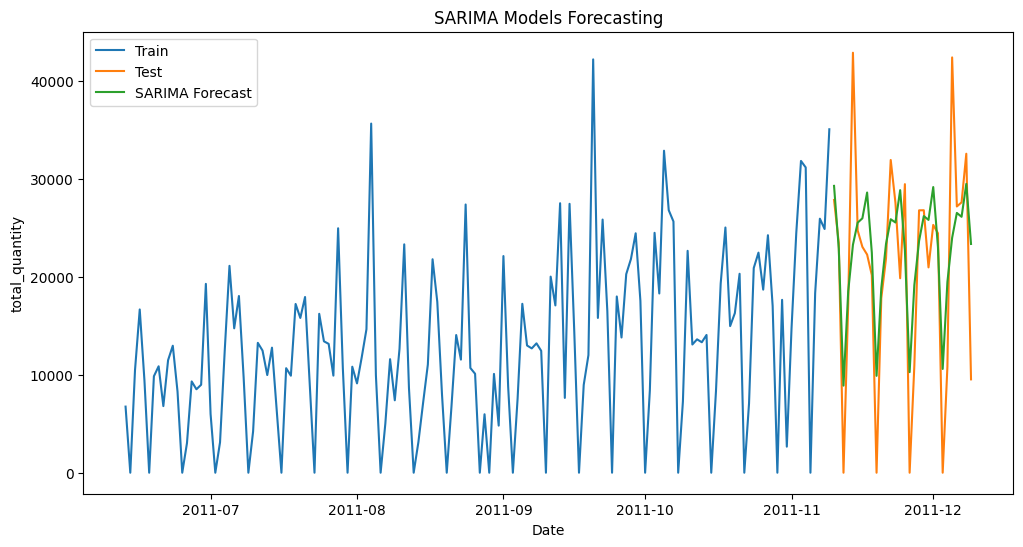

In [ ]:
# SARIMA Model
sarima_model = SARIMAX(train['total_quantity'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)).fit(disp=False)
sarima_forecast = sarima_model.forecast(steps=len(test))

plt.figure(figsize=(12, 6))
plt.plot(train.index[-150:], train['total_quantity'].iloc[-150:], label='Train')
plt.plot(test.index, test['total_quantity'], label='Test')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast')
plt.title('SARIMA Models Forecasting')
plt.xlabel('Date')
plt.ylabel('total_quantity')
plt.legend()
plt.show()

# Decomposition based Models
### 1. STL Decomposition
**STL (Seasonal and Trend decomposition using Loess) Decomposition** is a versatile method that breaks a time series into three components: **trend, seasonal, and remainder (residual)**. Forecasting can then be performed by **modeling each component separately** (e.g., using a trend model like Holt’s and extending the seasonal pattern) and recombining them. The STL method is robust to various seasonal patterns and **can handle irregular data**.

> STL uses **LOESS (locally weighted regression)** to smooth the data, allowing adaptability to non-linear trends and varying seasonality.

> After decomposition, the trend can be forecasted (e.g., with Holt’s method), the seasonal component can be extended (e.g., by repeating the last cycle), and the remainder is often ignored or modeled separately.

**Advantages:**
- Handles complex seasonality and trends better than simpler methods
- Useful for understanding underlying patterns.

**Limitations**:
- Requires a predefined seasonal period (e.g., 7)
- Forecasting accuracy depends on how well each component is modeled
- Residuals may still contain unmodeled patterns.

**STL Decomposition:**

The time series $ Y_t $ is decomposed as:
$$Y_t = T_t + S_t + R_t$$
Where:

$ T_t $ is the trend component,

$ S_t $ is the seasonal component,

$ R_t $ is the remainder (residual).

**LOESS Smoothing:**

The trend $ T_t $ and seasonal $ S_t $ are estimated using locally weighted regression. For a window of data points, weights are assigned based on distance, and a polynomial fit is applied.
Seasonal Extraction: The seasonal component is isolated by subtracting the trend and averaging over each season (e.g., each day of the week over multiple weeks).

#### **1.1 Trend Forecast:**
Uses a method like Holt’s Linear Trend:
$$T_{t+m} = L_t + m T_t$$
Where $ L_t $ is the last estimated level,

$ T_t $ is the last trend,

and $ m $ is the forecast horizon.

#### **1.2 Seasonal Forecast:**
Extend by repeating the last seasonal cycle:
$$S_{t+m} = S_{t-s+m \mod s}$$
Where $ s $ is the seasonal period (e.g., 7), and the modulo ensures cycling.
Combined Forecast (additive model):
$$F_{t+m} = T_{t+m} + S_{t+m}$$
(The remainder $ R_t $ is typically ignored unless modeled separately.)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


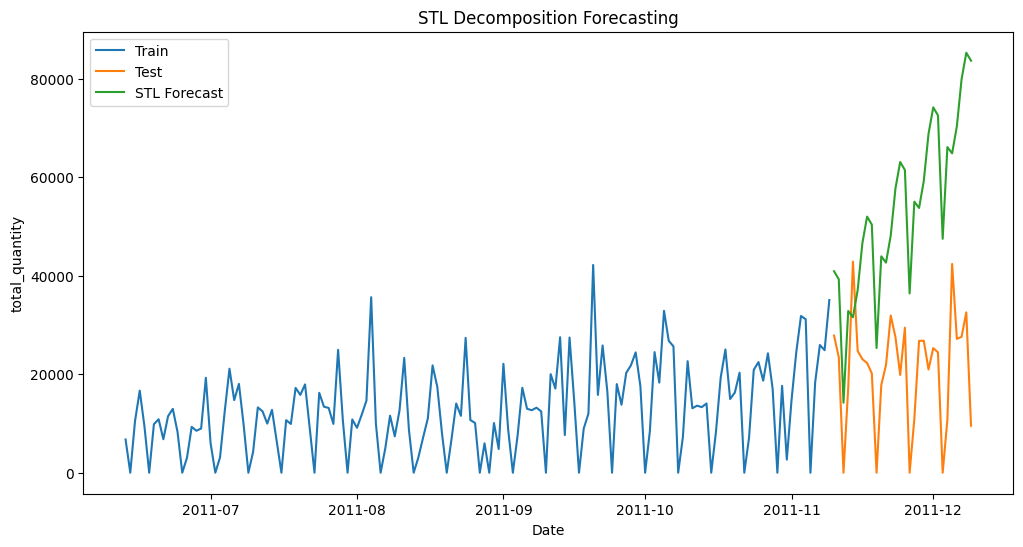

In [ ]:
# STL Decomposition + Forecasting
stl = STL(train['total_quantity'], period=7)
stl_result = stl.fit()
trend_forecast = Holt(stl_result.trend).fit().forecast(len(test))
seasonal_forecast = np.tile(stl_result.seasonal[-7:], int(np.ceil(len(test) / 7)))[:len(test)]
stl_forecast = trend_forecast + seasonal_forecast

plt.figure(figsize=(12, 6))
plt.plot(train.index[-150:], train['total_quantity'].iloc[-150:], label='Train')
plt.plot(test.index, test['total_quantity'], label='Test')
plt.plot(test.index, stl_forecast, label='STL Forecast')
plt.title('STL Decomposition Forecasting')
plt.xlabel('Date')
plt.ylabel('total_quantity')
plt.legend()
plt.show()

# Automated Models
### 1. AutoArima
AutoARIMA is an **automated version of the ARIMA** (AutoRegressive Integrated Moving Average) model that uses algorithms to select the optimal orders (p, d, q) and, if applicable, seasonal orders (P, D, Q, s) **without manual tuning of ARIMA parameters**.  

It uses criteria like **AIC (Akaike Information Criterion)** or **BIC (Bayesian Information Criterion)** to choose the best model from a range of candidate models.

**Advantages:**
- Reduces the need for expertise in time series analysis
- Handles both non-seasonal and seasonal data.

**Limitations**:
- Computationally intensive
- Performance depends on the quality of the input data and the range of parameters tested.

**ARIMA(p, d, q) Base Model:**
$$\nabla^d Y_t = c + \sum_{i=1}^p \phi_i \nabla^d Y_{t-i} + \sum_{j=1}^q \theta_j \epsilon_{t-j} + \epsilon_t$$
Where $ \nabla^d $ is the differencing operator,

$ \phi_i $ and $ \theta_j $ are AR and MA coefficients,

$ \epsilon_t $ is white noise.

**SARIMA(p, d, q)(P, D, Q, s) Extension:**
$$\nabla^d \nabla_s^D Y_t = c + \sum_{i=1}^p \phi_i \nabla^d Y_{t-i} + \sum_{j=1}^q \theta_j \epsilon_{t-j} + \sum_{i=1}^P \Phi_i \nabla_s^D Y_{t-i s} + \sum_{j=1}^Q \Theta_j \epsilon_{t-j s} + \epsilon_t$$
Where $ \nabla_s^D $ is seasonal differencing,

$ s $ is the seasonal period.

**Automation**:

AutoARIMA iterates over possible $ (p, d, q) $ and $ (P, D, Q) $ values, minimizing AIC:
$$\text{AIC} = -2 \log(L) + 2k$$
Where $ L $ is the likelihood,

$ k $ is the number of parameters.


### 2. Prophet
Prophet is an automated forecasting tool developed by Facebook, designed to handle time series with **strong seasonal effects and missing data**. It models the time series as a **sum of trend, seasonality and noise effects**.

It fits the model using a **Bayesian approach**, automatically tuning parameters via optimization.

**Advantages**:
- User-friendly
- Handles outliers and changes in trend
- Provides uncertainty intervals.

**Limitations**:
- Requires sufficient data
- Less flexible for highly irregular patterns.

**Prophet Model:**
$$y(t) = g(t) + s(t) + h(t) + \epsilon_t$$
Where:

$ g(t) $: Trend function (piecewise linear or logistic),

$ s(t) $: Seasonal component (Fourier series approximation),

$ h(t) $: Holiday effects,

$ \epsilon_t $: Error term (assumed Gaussian).


**Trend (piecewise linear):**
$$g(t) = (k + a(t) \cdot \delta)t + (m + a(t) \cdot \gamma)$$
Where $ k $ is growth rate
$ m $ is offset
$ a(t) $ is a step function at change points
$ \delta $ and $ \gamma $ are adjustments.

**Seasonality (Fourier series):**
$$s(t) = \sum_{n=1}^N \left( a_n \cos\left(\frac{2\pi n t}{P}\right) + b_n \sin\left(\frac{2\pi n t}{P}\right) \right)$$
Where $ P $ is the period, and $ a_n, b_n $ are coefficients.

DEBUG:cmdstanpy:input tempfile: /tmp/tmpou3xpmmw/mlj5cfzz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpou3xpmmw/dftzy50f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67864', 'data', 'file=/tmp/tmpou3xpmmw/mlj5cfzz.json', 'init=/tmp/tmpou3xpmmw/dftzy50f.json', 'output', 'file=/tmp/tmpou3xpmmw/prophet_modelu9gynsth/prophet_model-20250619130532.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:05:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:05:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


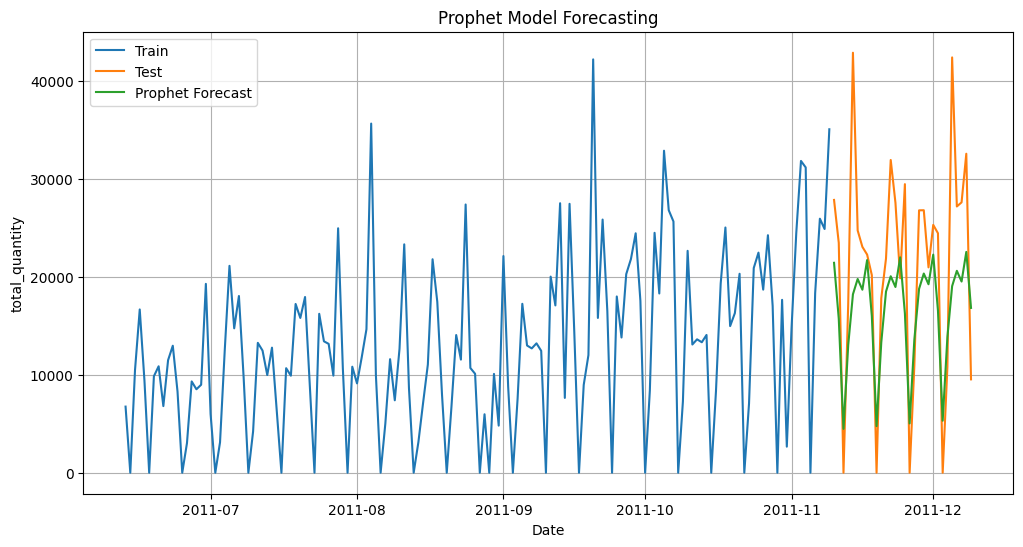

In [ ]:
prophet_df = train.reset_index().rename(columns={'invoice_date': 'ds', 'total_quantity': 'y'})

prophet_model = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True)
prophet_model.fit(prophet_df) # Initialization and fitting

future = prophet_model.make_future_dataframe(periods=len(test)) # Future dataframe for forecasting

prophet_forecast = prophet_model.predict(future)['yhat'].iloc[-len(test):]

plt.figure(figsize=(12, 6))
plt.plot(train.index[-150:], train['total_quantity'].iloc[-150:], label='Train')
plt.plot(test.index, test['total_quantity'], label='Test')
plt.plot(test.index, prophet_forecast, label='Prophet Forecast')
plt.title('Prophet Model Forecasting')
plt.xlabel('Date')
plt.ylabel('total_quantity')
plt.legend()
plt.grid(True)
plt.show()

### 3. TBATS
**TBATS (Trigonometric seasonality, Box-Cox transformation, ARMA errors, Trend, and Seasonal components)** is an automated model that handles multiple seasonalities and complex trends using a state space framework. This model is particularly useful for **high-frequency data**.

- **Box-Cox Transformation**: Stabilizes variance if the data is skewed.
- **Trend**: A damped or linear trend.
- **Seasonality**: Modeled with trigonometric functions to capture multiple seasonal periods.
- **ARMA Errors**: Captures residual autocorrelation.

This model **automatically estimates parameters**, including the number of seasonalities.

**Advantages**:
- Handles complex seasonality (e.g., daily and weekly) and non-linear trends
- Robust to irregular data.

**Limitations**:
- Computationally expensive
- Requires careful interpretation of results.

**TBATS Model:**
$$y_t = f(\lambda, l_{t-1}, b_{t-1}, s_{t-1}^{(j)}, \epsilon_t)$$
Where:

$ f(\lambda, \cdot) $ is the Box-Cox transformation with parameter $ \lambda $,

$ l_t $: Level,

$ b_t $: Trend (damped or linear),

$ s_t^{(j)} $: Seasonal components for $ j $ seasons (modeled with trigonometric terms),

$ \epsilon_t $: ARMA process for residuals.


**Seasonal Component (trigonometric):**
$$s_t^{(j)} = \sum_{k=1}^{K_j} s_{j,k,t}, \quad s_{j,k,t} = s_{j,k,t-1} \cos(\omega_{j,k}) + s_{j,k,t-1}^* \sin(\omega_{j,k}) + \eta_{j,k,t}$$
Where $ \omega_{j,k} = 2\pi k / m_j $ ( $ m_j $ is the seasonal period)

$ \eta_{j,k,t} $ is noise.